🖼 Previewing NORMALIZATION on random samples...


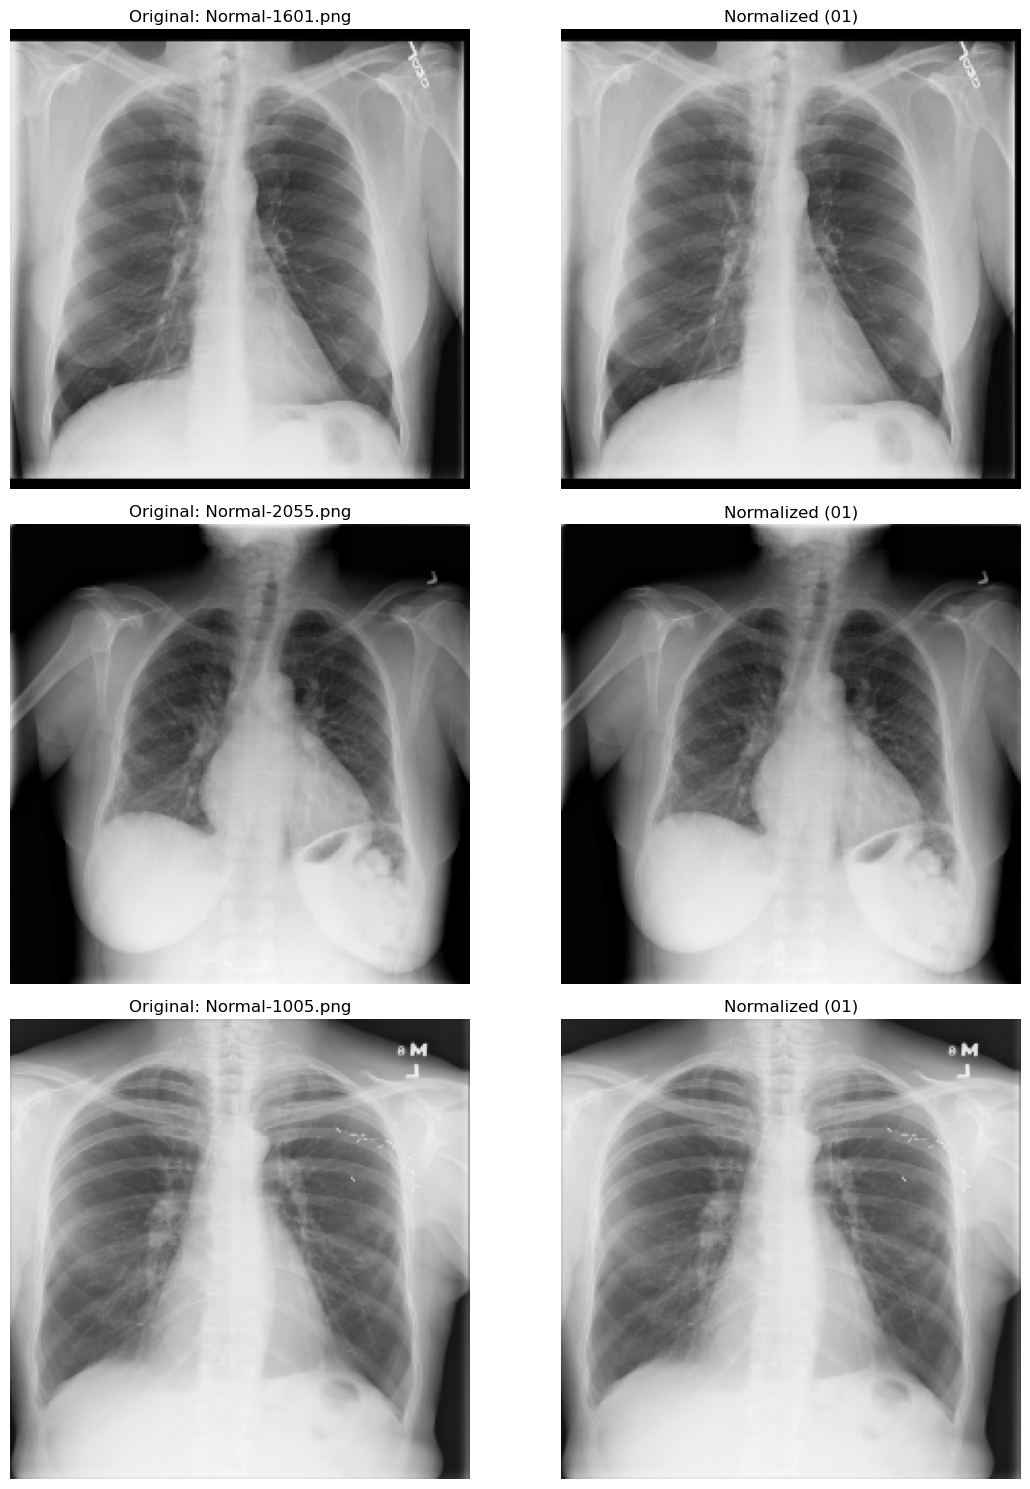

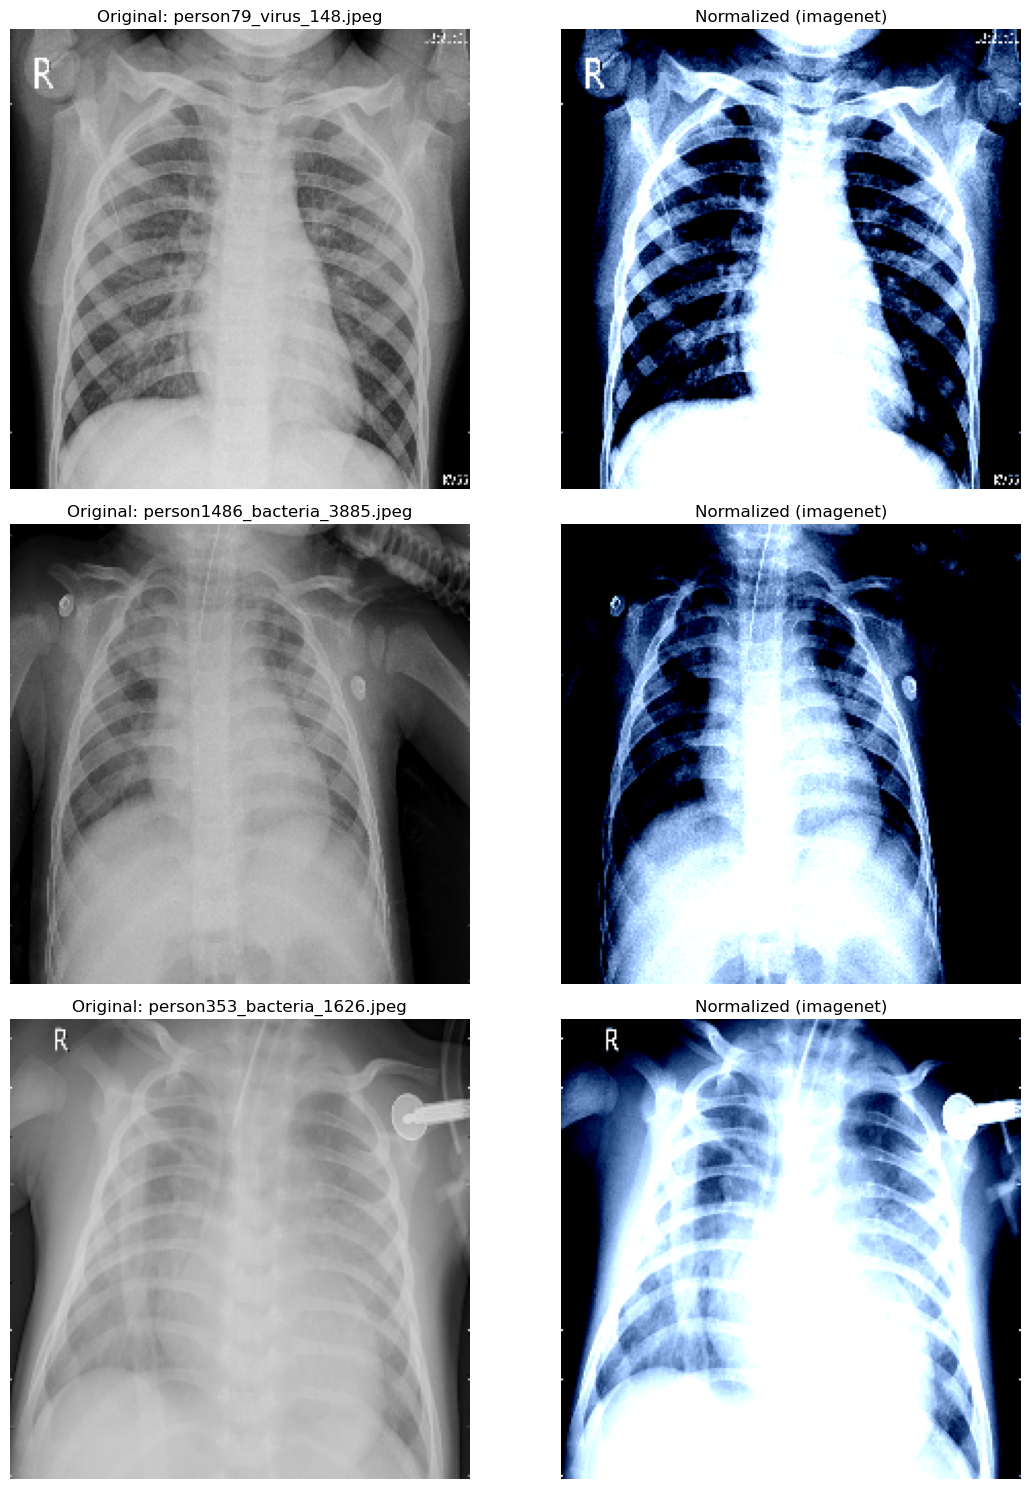

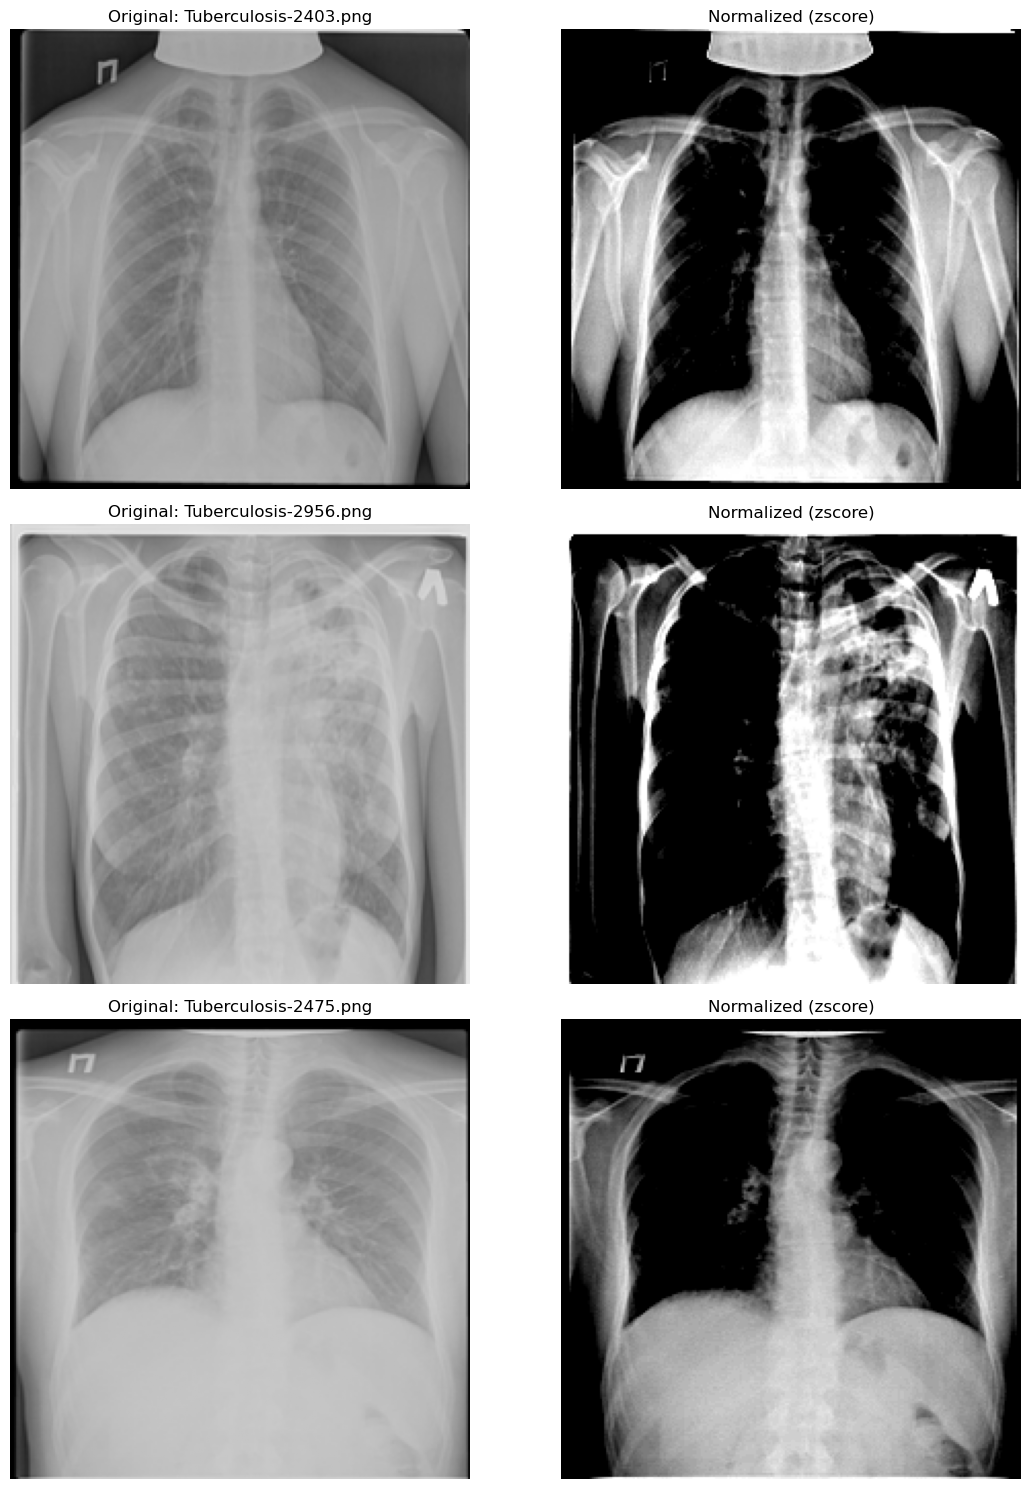

In [8]:
from pathlib import Path
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Configs
DATASET_PATH = Path("../data")
IMAGE_SIZE = (224, 224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Normalization Functions
def normalize_image(img, method='01'):
    """Normalize image using chosen method."""
    img = img.astype(np.float32) / 255.0  # Default: Min-Max [0, 1]

    if method == 'imagenet':  # ImageNet mean/std
        for i in range(3):
            img[:, :, i] = (img[:, :, i] - IMAGENET_MEAN[i]) / IMAGENET_STD[i]
    elif method == 'zscore':  # Z-score normalization
        mean, std = img.mean(), img.std() + 1e-8
        img = (img - mean) / std

    return img

# Show sample images with and without normalization
def preview_normalization(split, category, n=3, normalize_type='01'):
    folder = DATASET_PATH / split / category
    if not folder.exists():
        print(f"⚠️ Folder '{folder}' not found!")
        return

    images = list(folder.glob('*'))
    
    if len(images) == 0:
        print(f"No images found in '{split}/{category}'")
        return
    
    # Randomly select images
    random_images = random.sample(images, min(n, len(images)))
    
    plt.figure(figsize=(12, 5 * n))
    for i, img_file in enumerate(random_images):
        img = cv2.imread(str(img_file))  # Load as BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = cv2.resize(img, IMAGE_SIZE)  # Resize to 224x224

        # Normalized version
        norm_img = normalize_image(img, method=normalize_type)

        # Plot original
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img / 255.0)  # Scale back to [0, 1] for display
        plt.title(f"Original: {img_file.name}")
        plt.axis('off')

        # Plot normalized
        plt.subplot(n, 2, 2 * i + 2)
        plt.imshow(np.clip(norm_img, 0, 1))  # Clip values for valid display
        plt.title(f"Normalized ({normalize_type})")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 🎲 Show samples with and without normalization
print("🖼 Previewing NORMALIZATION on random samples...")
preview_normalization('train', 'normal', n=3, normalize_type='01')  # 0-1 scaling
preview_normalization('val', 'pneumonia', n=3, normalize_type='imagenet')  # ImageNet
preview_normalization('test', 'tuberculosis', n=3, normalize_type='zscore')  # Z-score


Found 6 images in ..\data


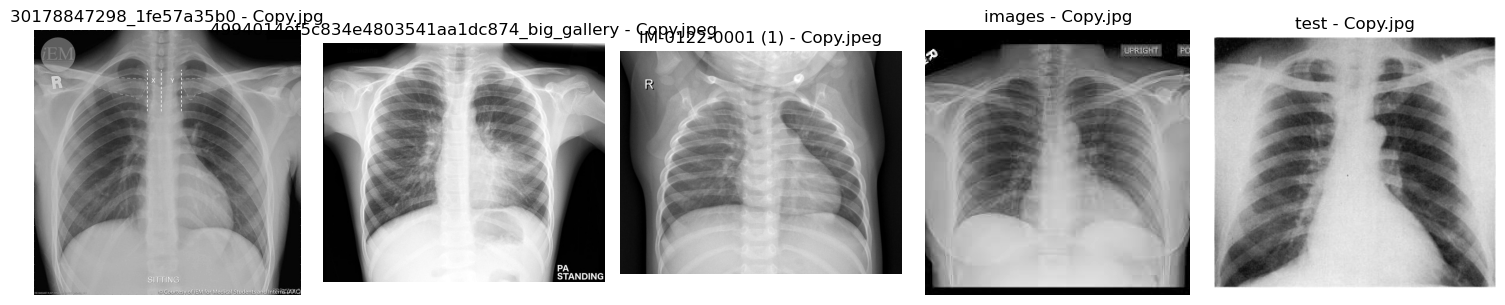

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

# Set path to test image folder
TEST_IMAGE_PATH = Path("../data")  # or wherever your images are

# List image files (filter common image formats)
image_files = [f for f in TEST_IMAGE_PATH.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

print(f"Found {len(image_files)} images in {TEST_IMAGE_PATH}")

# Display first few images
def show_test_images(images, n=5):
    plt.figure(figsize=(15, 3))
    for i, img_file in enumerate(images[:n]):
        img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(img_file.name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_test_images(image_files)


Normalizing


Found 8 images.


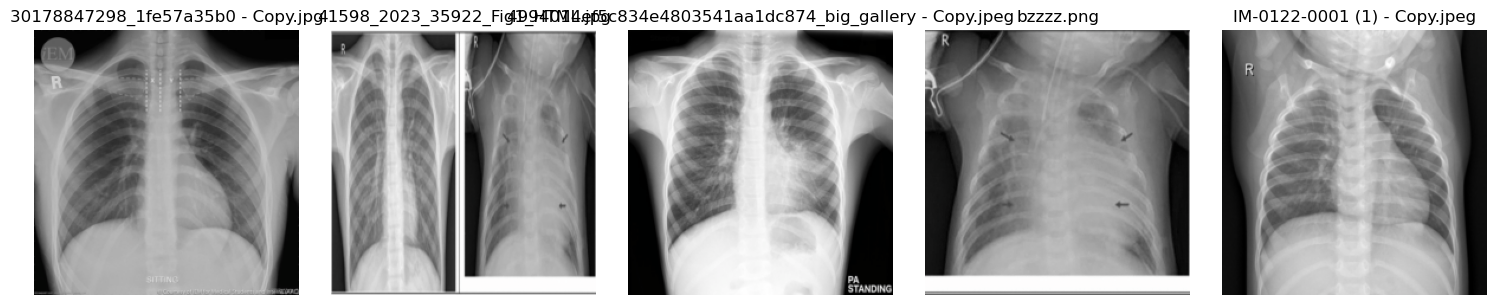

In [10]:
from pathlib import Path
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch

# 🔧 Config
TEST_IMAGE_PATH = Path("../data")
IMAGE_SIZE = (224, 224)

# PyTorch transform (same as ResNet training)
resnet_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),  # Converts to [0, 1] float tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Optional: inverse normalization (for display)
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip([0.485, 0.456, 0.406],
                               [0.229, 0.224, 0.225])],
    std=[1/s for s in [0.229, 0.224, 0.225]]
)

# Get image files
image_files = [f for f in TEST_IMAGE_PATH.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]
print(f"Found {len(image_files)} images.")

# Display function
def show_normalized_images(image_paths, transform, n=5):
    plt.figure(figsize=(15, 3))
    for i, img_path in enumerate(image_paths[:n]):
        img = Image.open(img_path).convert("RGB")
        img_tensor = transform(img)
        img_tensor = inv_normalize(img_tensor)  # Undo normalization for display
        img_np = img_tensor.permute(1, 2, 0).numpy()  # Convert CHW -> HWC for matplotlib
        
        plt.subplot(1, n, i+1)
        plt.imshow(img_np.clip(0, 1))  # Ensure pixel values are valid
        plt.title(img_path.name)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# 🔥 Run it
show_normalized_images(image_files, resnet_transform)
